<a href="https://colab.research.google.com/github/saffarizadeh/BUAN4061/blob/main/Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://saffarizadeh.com/Logo.png" width="300px"/>

# *BUAN 4061: Advanced Business Analytics*

# **Recurrent Neural Networks**

Instructor: Dr. Kambiz Saffarizadeh

---

A basic neural network (what we saw before).

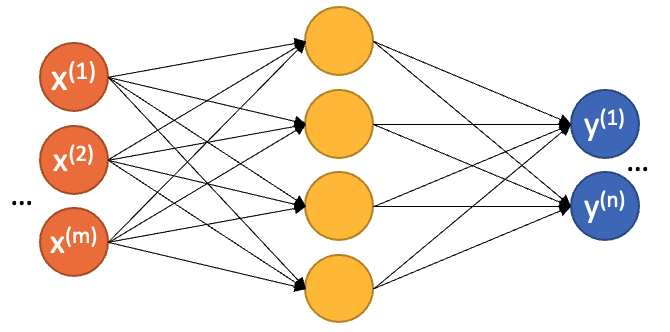

Let's represent the hidden layers by a single box (a black-box!).

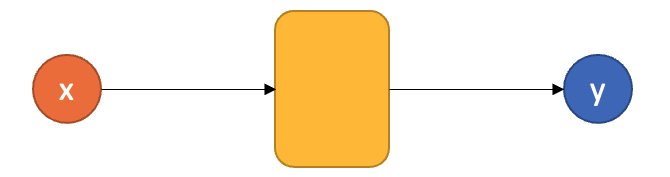

Let's rotate the figure and repeat it for each time step.

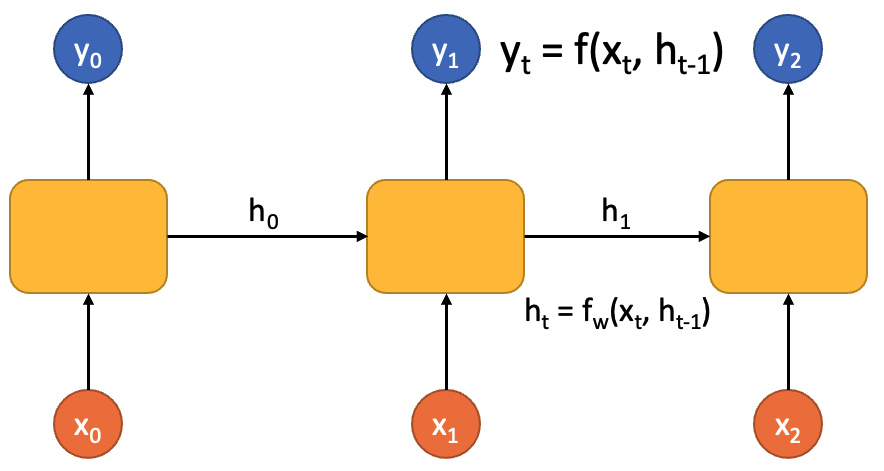

Let's create a model like this in the context of natural language processing.

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import string

# Data

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json

--2022-04-20 15:53:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json.2’

sarcasm.json.2      100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2022-04-20 15:53:53 (118 MB/s) - ‘sarcasm.json.2’ saved [5643545/5643545]



In [4]:
with open("sarcasm.json", 'r') as f:
    dataset = json.load(f)

In [5]:
dataset[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [6]:
def clean_document(document):
  document = document.lower()
  document = document.replace(',', ' , ')
  document = document.replace('.', ' . ')
  document = document.replace('-', ' - ')
  document = document.replace('/', ' / ')
  soup = BeautifulSoup(document)
  document = soup.get_text()
  words = document.split()
  filtered_document = ''
  for word in words:
    word = word.translate(table)
    if word not in stopwords:
      filtered_document = filtered_document + word + ' '
  return filtered_document

In [7]:
documents = []
labels = []
urls = []

for item in dataset:
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])
  document = clean_document(item['headline'])
  documents.append(document)

# Vectorization

In [8]:
vocab_size = 2000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [9]:
training_docs = documents[0:training_size]
validation_docs = documents[training_size:]

training_labels = labels[0:training_size]
validation_labels = labels[training_size:]

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_docs)
word_index = tokenizer.word_index

In [11]:
training_sequences = tokenizer.texts_to_sequences(training_docs)
training_padded = pad_sequences(training_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

In [12]:
validation_sequences = tokenizer.texts_to_sequences(validation_docs)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)

In [13]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

# Model

In [14]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dense(24, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [15]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          32000     
                                                                 
 bidirectional (Bidirectiona  (None, 200)              93600     
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                4824      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 130,449
Trainable params: 130,449
Non-trainable params: 0
_________________________________________________________________


FYI: Inside each LSTM cell may look like the following figure.

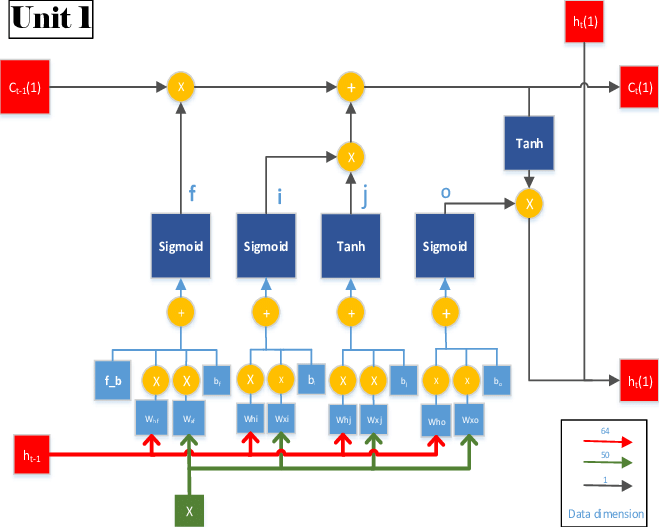

Credit: Wen, S., Wei, H., Yang, Y., Guo, Z., Zeng, Z, 2019 "Memristive LSTM Network for Sentiment Analysis," IEEE TRANSACTIONS ON SYSTEMS MAN AND CYBERNETICS: SYSTEMS

In [16]:
history1 = model1.fit(training_padded, training_labels, epochs=20, validation_data=(validation_padded, validation_labels))

# To reduce the wait time in the classroom, we run the model with only 20 epochs.
# But we need 100-150 epochs to better investigate the learning curves.

Epoch 1/20
719/719 [==============================] - 17s 18ms/step - loss: 0.9408 - accuracy: 0.5961 - val_loss: 0.5774 - val_accuracy: 0.7573
Epoch 2/20
719/719 [==============================] - 12s 17ms/step - loss: 0.5789 - accuracy: 0.7225 - val_loss: 0.5313 - val_accuracy: 0.7689
Epoch 3/20
719/719 [==============================] - 12s 16ms/step - loss: 0.4930 - accuracy: 0.7928 - val_loss: 0.5118 - val_accuracy: 0.7611
Epoch 4/20
719/719 [==============================] - 12s 16ms/step - loss: 0.4582 - accuracy: 0.8067 - val_loss: 0.5090 - val_accuracy: 0.7549
Epoch 5/20
719/719 [==============================] - 12s 17ms/step - loss: 0.4398 - accuracy: 0.8129 - val_loss: 0.4904 - val_accuracy: 0.7673
Epoch 6/20
719/719 [==============================] - 12s 17ms/step - loss: 0.4227 - accuracy: 0.8219 - val_loss: 0.4817 - val_accuracy: 0.7765
Epoch 7/20
719/719 [==============================] - 12s 16ms/step - loss: 0.4039 - accuracy: 0.8280 - val_loss: 0.4656 - val_accuracy:

In [17]:
def plot_graphs(history, set_name):
  plt.plot(history.history[set_name])
  plt.plot(history.history['val_' + set_name])
  plt.xlabel("Epochs")
  plt.ylabel(set_name)
  plt.legend([set_name, 'val_' + set_name])
  plt.show()

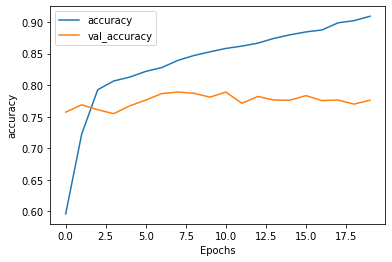

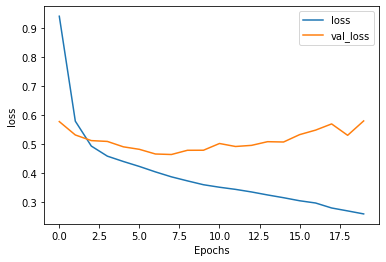

In [18]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

# Revised Model

In [19]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.2)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.2)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model2.compile(loss = 'binary_crossentropy',
               optimizer = tf.keras.optimizers.Adam(learning_rate=0.000008),
               metrics = ['accuracy'])

In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          32000     
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        93600     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                4824      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 371,249
Trainable params: 371,249
Non-tr

In [21]:
history2 = model2.fit(training_padded, training_labels, epochs=20, validation_data=(validation_padded, validation_labels))

# To reduce the wait time in the classroom, we run the model with only 20 epochs.
# But we need 100-150 epochs to better investigate the learning curves.

Epoch 1/20
719/719 [==============================] - 31s 34ms/step - loss: 0.6882 - accuracy: 0.5594 - val_loss: 0.6826 - val_accuracy: 0.5700
Epoch 2/20
719/719 [==============================] - 21s 30ms/step - loss: 0.6845 - accuracy: 0.5596 - val_loss: 0.6814 - val_accuracy: 0.5700
Epoch 3/20
719/719 [==============================] - 21s 30ms/step - loss: 0.6829 - accuracy: 0.5596 - val_loss: 0.6789 - val_accuracy: 0.5700
Epoch 4/20
719/719 [==============================] - 21s 30ms/step - loss: 0.6789 - accuracy: 0.5599 - val_loss: 0.6716 - val_accuracy: 0.5727
Epoch 5/20
719/719 [==============================] - 22s 30ms/step - loss: 0.6611 - accuracy: 0.6004 - val_loss: 0.6459 - val_accuracy: 0.6190
Epoch 6/20
719/719 [==============================] - 22s 31ms/step - loss: 0.6399 - accuracy: 0.6307 - val_loss: 0.6348 - val_accuracy: 0.6274
Epoch 7/20
719/719 [==============================] - 22s 30ms/step - loss: 0.6226 - accuracy: 0.6483 - val_loss: 0.6122 - val_accuracy:

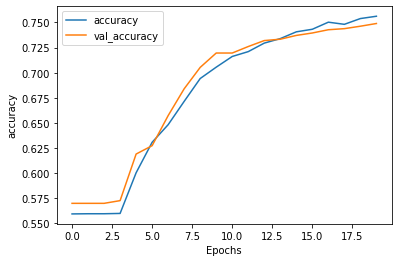

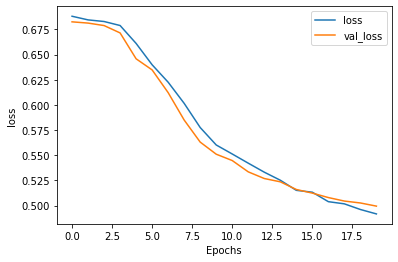

In [22]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

# Using the Models

In [23]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

In [24]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [25]:
predictions1 = model1.predict(test_padded)
predictions1

array([[0.9372225 ],
       [0.72550935],
       [0.940328  ],
       [0.940328  ]], dtype=float32)

In [26]:
predictions2 = model2.predict(test_padded)
predictions2

array([[0.40501526],
       [0.23860648],
       [0.92910093],
       [0.87939197]], dtype=float32)

# Saving the Embeddings

In [27]:
weights1 = model1.layers[0].get_weights()[0]

In [28]:
weights2 = model2.layers[0].get_weights()[0]

In [29]:
weights1.shape

(2000, 16)

In [30]:
reverse_word_index = {}

for (key, value) in word_index.items():
  reverse_word_index[value] = key

# Alternative code:
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [31]:
import pandas as pd

In [32]:
df1 = pd.DataFrame(weights1)
df1['word'] = [reverse_word_index[word_num] for word_num in range(1, vocab_size+1)]
df1 = df1.set_index('word')
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
word,,,,,,,,,,,,,,,,
<OOV>,0.046936,0.115460,-0.028125,0.040335,-0.032348,-0.090978,0.030739,0.081768,-0.065378,-0.074479,0.092442,-0.033503,-0.081347,0.031637,-0.063039,-0.138111
new,-0.007938,0.010794,0.013966,-0.053286,-0.000280,-0.022325,-0.046550,0.002462,0.070843,-0.012015,-0.001831,-0.015161,-0.037066,-0.106624,0.002148,0.028694
trump,-0.099765,-0.045377,-0.051489,-0.041042,0.006045,0.114713,-0.089260,0.118556,0.120806,0.112339,-0.058702,0.027712,-0.029288,0.114330,0.057171,0.153765
man,0.211266,0.212699,0.139028,0.199262,-0.336281,-0.175983,0.197428,0.394279,-0.212503,-0.242316,0.224947,-0.267012,0.008985,-0.095765,-0.119510,-0.322706
not,-0.183803,-0.135680,-0.240159,-0.242631,0.224346,0.187611,-0.212220,-0.047324,0.170325,0.202585,-0.167244,0.263355,0.151950,0.287572,0.155881,0.082642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
laid,0.222961,0.277606,0.108848,0.160710,-0.247907,-0.300261,0.161164,0.265216,-0.223599,-0.221615,0.242603,-0.233615,-0.115603,-0.101270,-0.232625,-0.278032
add,-0.202298,-0.194507,0.004681,-0.046098,-0.035934,0.182485,-0.069864,0.095026,0.151858,0.112942,-0.108770,-0.011760,-0.068704,-0.033307,0.117850,0.161957
communities,-0.092893,-0.120897,-0.262806,-0.214784,0.018172,0.003388,-0.157661,0.029471,0.114695,0.082532,-0.103814,0.275641,0.385510,0.312697,0.066401,0.032537


In [33]:
df2 = pd.DataFrame(weights2)
df2['word'] = [reverse_word_index[word_num] for word_num in range(1, vocab_size+1)]
df2 = df2.set_index('word')
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
word,,,,,,,,,,,,,,,,
<OOV>,-0.015206,-0.038163,0.035874,0.035721,0.009724,0.021837,-0.025942,0.013152,-0.021489,0.019090,0.041387,-0.016781,-0.058053,0.000578,0.013159,0.032848
new,-0.014850,0.011132,0.044127,0.009352,-0.001239,-0.046744,0.002022,0.024920,0.010849,0.038993,0.004965,0.055999,0.044226,-0.040161,-0.000477,0.008295
trump,0.021630,0.058110,-0.044234,-0.041658,-0.041947,0.006089,0.024703,0.021264,-0.014055,0.036878,0.003529,0.002871,-0.009226,0.026905,0.008725,0.010556
man,0.061381,0.002974,-0.010637,-0.008268,0.078995,0.067220,-0.009814,-0.072721,0.004971,-0.064156,0.008195,-0.069266,0.020741,0.011675,0.054839,0.007923
not,-0.039180,0.038809,-0.041548,-0.000434,0.014545,-0.046014,0.079689,-0.001287,0.046934,0.073247,-0.001085,-0.013189,-0.034506,-0.041129,-0.056272,-0.051325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
laid,0.029637,-0.026552,-0.035916,0.033255,0.023795,-0.004453,0.007401,-0.043500,-0.055050,-0.015789,0.001875,0.040916,0.038499,0.011839,0.036896,0.041997
add,-0.015873,-0.038318,-0.030841,-0.001288,-0.041915,-0.034614,-0.027092,-0.010332,0.022996,-0.006162,-0.003403,0.045958,-0.048712,-0.018069,0.023801,0.027827
communities,-0.033857,0.004469,-0.047690,-0.008391,-0.028659,-0.053944,-0.036094,-0.018912,0.039119,0.041937,-0.051559,0.028754,0.014074,-0.004660,0.012547,-0.016700


In [34]:
from scipy import spatial

In [35]:
1 - spatial.distance.cosine(df1.loc['trump'], df1.loc['trump'])

1.0

Model 1

In [36]:
1 - spatial.distance.cosine(df1.loc['biden'], df1.loc['sanders'])

0.8657546639442444

In [37]:
1 - spatial.distance.cosine(df1.loc['biden'], df1.loc['trump'])

-0.5118131041526794

Model 2

In [38]:
1 - spatial.distance.cosine(df2.loc['biden'], df2.loc['sanders'])

0.347954124212265

In [39]:
1 - spatial.distance.cosine(df2.loc['biden'], df2.loc['trump'])

-0.4640941023826599